### Code by wenlong sun, April 2025

### if you think this is helpful, please cite:

*Sun, Wenlong, et al. "Debiasing the human-recommender system feedback loop in collaborative filtering." Companion Proceedings of The 2019 World Wide Web Conference. 2019.*




In [1]:
# Download movielens dataset
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2025-05-25 17:21:05--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  21.8MB/s    in 0.2s    

2025-05-25 17:21:05 (21.8 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:

# Step 1: Download the MovieLens 100k dataset
def get_movie_lens_data(dataset):

  # Load the ratings data into a pandas DataFrame
  file_name = 'ml-100k/'+ dataset + '.base'
  ratings_df = pd.read_csv(file_name, sep='\t', names=['user_id', 'item_id', 'rating','timestamp'])
  return ratings_df

def get_test_data(dataset):
  file_name = 'ml-100k/'+ dataset + '.test'
  test_df = pd.read_csv(file_name, sep='\t', names=['user_id', 'item_id', 'rating','timestamp'])
  return test_df

In [5]:
# Generate or load data
df = get_movie_lens_data('u1')

# Split data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Get number of unique users and items
num_users = df['user_id'].max() + 1
num_items = df['item_id'].max() + 1

print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")

train_df.head()

Number of unique users: 944
Number of unique items: 1683


,user_id,item_id,rating,timestamp
3822,64,436,5,889739625
35562,493,264,3,884129923
4883,87,578,3,879875940
71170,864,121,4,877214085
25665,405,208,5,885547124


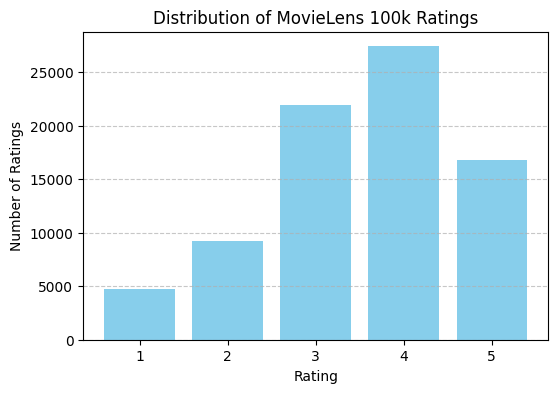

In [6]:
# Get unique rating values and their counts
rating_counts = df['rating'].value_counts().sort_index()

# Plot the rating distribution
plt.figure(figsize=(6, 4))
plt.bar(rating_counts.index, rating_counts.values, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Distribution of MovieLens 100k Ratings')
plt.xticks(rating_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
# Step 2: Create PyTorch Dataset
class RecommenderDataset(Dataset):
    """Dataset for training a recommendation model."""
    def __init__(self, user_ids, item_ids, ratings):
        self.user_ids = torch.tensor(user_ids, dtype=torch.long)
        self.item_ids = torch.tensor(item_ids, dtype=torch.long)
        self.ratings = torch.tensor(ratings, dtype=torch.float)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return {
            'user_id': self.user_ids[idx],
            'item_id': self.item_ids[idx],
            'rating': self.ratings[idx]
        }


In [8]:

# Step3: define regularization term
class CustomRMSELoss(nn.Module):
    def __init__(self, regularization_weight=0.01):
        super(CustomRMSELoss, self).__init__()
        self.regularization_weight = regularization_weight

    def forward(self, predictions, targets, user_embedding, item_embedding):
        mse_loss = torch.mean((predictions - targets)**2)

        # calculate blindspot-aware regularization term
        embed_diff = user_embedding - item_embedding
        blindspot_reg = torch.mean(torch.sum(embed_diff**2, dim=1))

        # item reg
        item_reg = 0.01* torch.mean(torch.sum(item_embedding**2, dim=1))

        # user reg
        user_reg = 0.01* torch.mean(torch.sum(user_embedding**2, dim=1))


        total_loss = mse_loss + self.regularization_weight * blindspot_reg + item_reg + user_reg

        return total_loss, mse_loss, blindspot_reg

In [9]:
# Step 4: Define the Recommender Model
class MatrixFactorizationModel(nn.Module):
    """Collaborative filtering model using matrix factorization."""
    def __init__(self, num_users, num_items, embedding_dim=50):
        super(MatrixFactorizationModel, self).__init__()
        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)
        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)

        # Initialize embeddings and biases
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)
        nn.init.zeros_(self.user_biases.weight)
        nn.init.zeros_(self.item_biases.weight)

    def forward(self, user_id, item_id):
        # Get embeddings and biases
        user_embedding = self.user_embeddings(user_id)
        item_embedding = self.item_embeddings(item_id)
        user_bias = self.user_biases(user_id).squeeze()
        item_bias = self.item_biases(item_id).squeeze()

        # Calculate dot product of user and item embeddings
        dot_product = torch.sum(user_embedding * item_embedding, dim=1)

        # Add biases to the dot product
        prediction = user_bias + item_bias + dot_product

        return prediction, user_embedding, item_embedding

In [10]:
# Step 5: Training function

#p1:  check the rmse for the testing dataset
def check_rmse_for_test_data(model, test_loader):

  model.eval()
  test_se = 0.0
  with torch.no_grad():
      for batch in test_loader:
          user_ids = batch['user_id']
          item_ids = batch['item_id']
          ratings = batch['rating']

          # forward pass
          predictions,user_embd, item_embd = model(user_ids, item_ids)
          test_se += (predictions - ratings)**2

  rmse = np.sqrt(test_se[0].item()/len(test_loader))
  print(f"sum of square error is {test_se[0].item()}, length of the test data is {len(test_loader)}")
  return rmse

# p2:
def train_model(model, train_loader, val_loader, test_loader, regularization_weight,
                num_epochs=2, learning_rate=0.001, weight_decay=0.0001):
    """Train the recommender model."""
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = CustomRMSELoss(regularization_weight)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            user_ids = batch['user_id']
            item_ids = batch['item_id']
            ratings = batch['rating']

            # Forward pass
            predictions, user_embedding, item_embedding = model(user_ids, item_ids)

            # Calculate loss
            loss, mse, reg = loss_fn(predictions, ratings,user_embedding, item_embedding)

            # Zero the gradients
            optimizer.zero_grad()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                user_ids = batch['user_id']
                item_ids = batch['item_id']
                ratings = batch['rating']

                # forward pass
                predictions,user_embd, item_embd = model(user_ids, item_ids)
                loss, mse, reg = loss_fn(predictions, ratings, user_embd, item_embd)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    test_rmse = check_rmse_for_test_data(model, test_loader)
    print(f"Test RMSE: {test_rmse}")

    return train_losses, val_losses, test_rmse

In [11]:
# Step 6: Main execution function
def build_recommender_system(data_name):
    """Build and train a recommender system."""


    # Generate or load data
    df = get_movie_lens_data(data_name)

    # Split data into train and validation sets
    train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

    # Get number of unique users and items
    num_users = df['user_id'].max() + 1
    num_items = df['item_id'].max() + 1

    # Create datasets
    train_dataset = RecommenderDataset(
        train_df['user_id'].values,
        train_df['item_id'].values,
        train_df['rating'].values
    )

    val_dataset = RecommenderDataset(
        val_df['user_id'].values,
        val_df['item_id'].values,
        val_df['rating'].values
    )

    test_df = get_test_data(data_name)
    test_dataset = RecommenderDataset(
      test_df['user_id'].values,
      test_df['item_id'].values,
      test_df['rating'].values)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    print(f"train_df shape: {train_df.shape}")
    print(f"val_df shape: {val_df.shape}")
    print(f"test_df shape: {test_df.shape}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Initialize model
    model = MatrixFactorizationModel(num_users, num_items, embedding_dim=60)

    # get the total number of trainable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters: {total_params}")

    # Train model
    train_losses, val_losses, test_rmse = train_model(
        model,
        train_loader,
        val_loader,
        test_loader,
        regularization_weight=0.015,
        num_epochs=100,
        learning_rate=0.00015
    )

    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Get recommendations for a sample user
    return model, df, train_losses, val_losses, test_rmse

train_df shape: (72000, 4)
val_df shape: (8000, 4)
test_df shape: (20000, 4)
Total number of trainable parameters: 160247
Epoch 5/100, Train Loss: 2.5550, Val Loss: 2.2351
Epoch 10/100, Train Loss: 1.1122, Val Loss: 1.1775
Epoch 15/100, Train Loss: 0.9552, Val Loss: 1.0415
Epoch 20/100, Train Loss: 0.9185, Val Loss: 1.0113
Epoch 25/100, Train Loss: 0.9035, Val Loss: 0.9994
Epoch 30/100, Train Loss: 0.8941, Val Loss: 0.9936
Epoch 35/100, Train Loss: 0.8863, Val Loss: 0.9907
Epoch 40/100, Train Loss: 0.8781, Val Loss: 0.9869
Epoch 45/100, Train Loss: 0.8687, Val Loss: 0.9837
Epoch 50/100, Train Loss: 0.8576, Val Loss: 0.9797
Epoch 55/100, Train Loss: 0.8444, Val Loss: 0.9747
Epoch 60/100, Train Loss: 0.8297, Val Loss: 0.9719
Epoch 65/100, Train Loss: 0.8146, Val Loss: 0.9683
Epoch 70/100, Train Loss: 0.7991, Val Loss: 0.9674
Epoch 75/100, Train Loss: 0.7830, Val Loss: 0.9669
Epoch 80/100, Train Loss: 0.7660, Val Loss: 0.9668
Epoch 85/100, Train Loss: 0.7474, Val Loss: 0.9670
Epoch 90/100

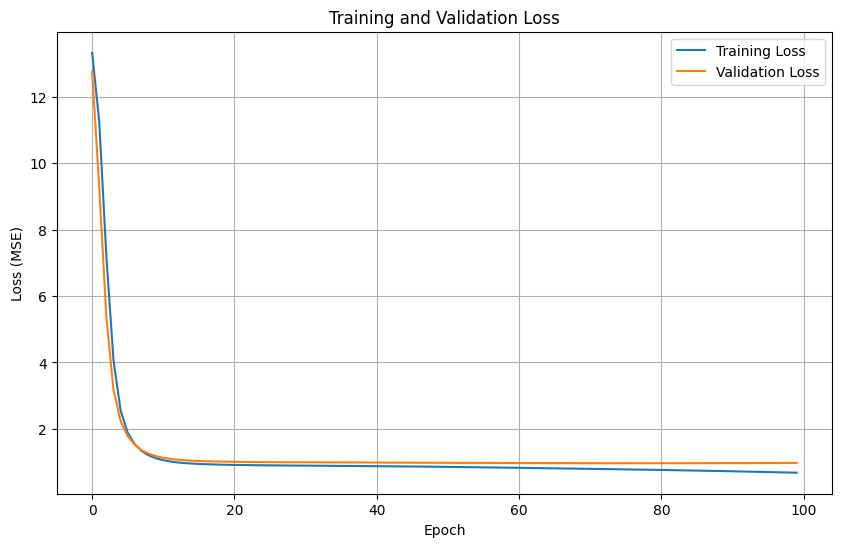

In [12]:
model, df, train_losses, val_losses, test_rmse = build_recommender_system('u1')

Plot saved as 100k_model_loss2.png


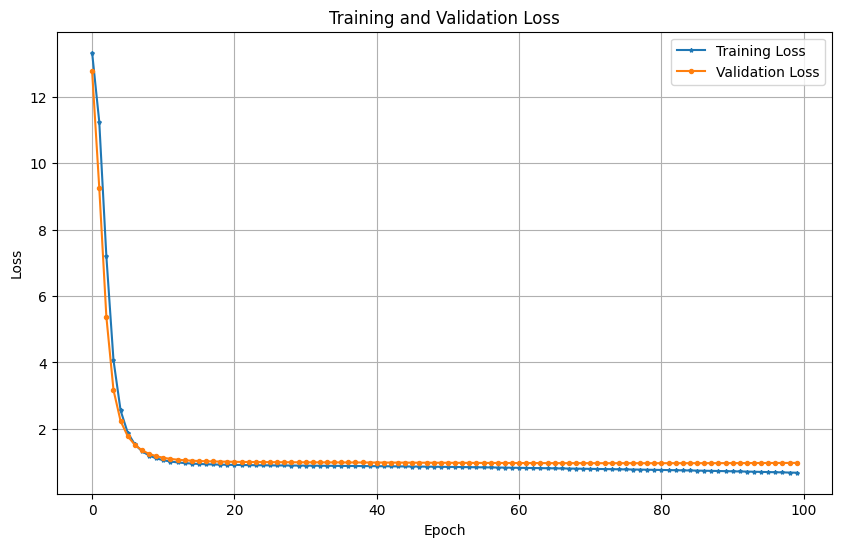

In [13]:
def save_loss_plot(filename='100k_model_loss2.png', dpi=300):
    plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    print(f"Plot saved as {filename}")


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss',marker='*',markersize=2.9)
plt.plot(val_losses, label='Validation Loss',marker='o',markersize=2.9)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Call this function when you want to save the plot
save_loss_plot()

Plot saved as 100k_model_loss1.png


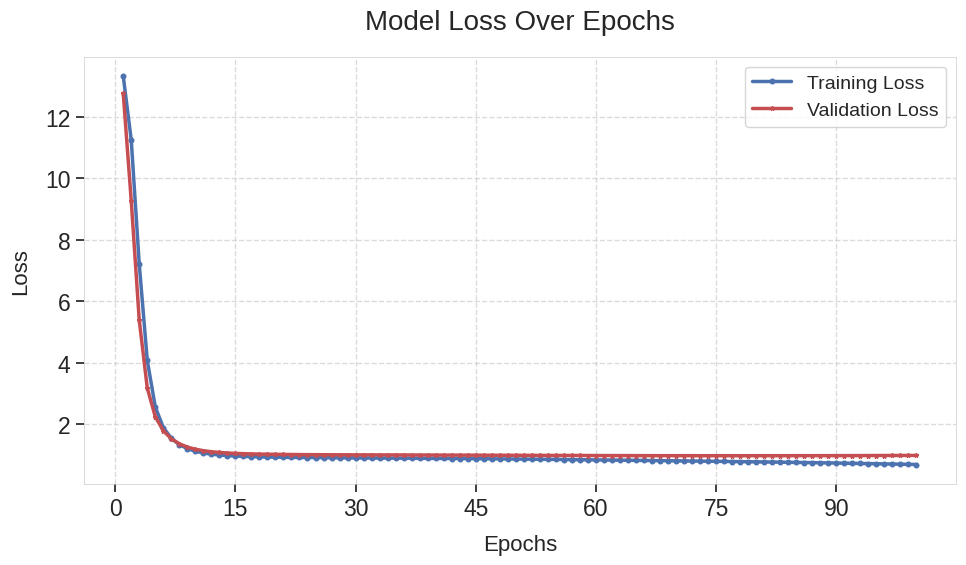

In [14]:
# Convert to pandas DataFrame for easier manipulation
import seaborn as sns
from matplotlib.ticker import MaxNLocator

num_epochs = [i+1 for i in range(100)]
history_df = pd.DataFrame({
    'epoch': num_epochs,
    'train_loss': train_losses,
    'val_loss': val_losses
})

# Configure the plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.5)

# Create a figure with a specific size
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history_df['epoch'], history_df['train_loss'], 'o-', linewidth=2.5,
         label='Training Loss', color='#4C72B0', markersize=3.3)
plt.plot(history_df['epoch'], history_df['val_loss'], '*-', linewidth=2.5,
         label='Validation Loss', color='#C44E52', markersize=3.3)


# Customize the plot
plt.title('Model Loss Over Epochs', fontsize=20, pad=20)
plt.xlabel('Epochs', fontsize=16, labelpad=10)
plt.ylabel('Loss', fontsize=16, labelpad=10)
plt.legend(loc='upper right', fontsize=14, frameon=True)

# Set integer ticks for x-axis
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Customize the spines
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.5)

# Improve the layout
plt.tight_layout()
# Function to save the plot
def save_loss_plot(filename='100k_model_loss1.png', dpi=300):
    plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    print(f"Plot saved as {filename}")

# Call this function when you want to save the plot
save_loss_plot()

# Show the plot
plt.show()

In [ ]:
# check the test error for all other test sets u2,u3,u4,u5
datasets =['u2','u3','u4','u5']
for dataset in datasets:
  _, _, train_losses, val_losses, test_rmse = build_recommender_system(dataset)
  print(f"test RMSE for u5 is {test_rmse}")

In [15]:


# Step 7: Generate top-N recommendations for a user
def recommend_items(model, user_id, item_ids, top_n=5):
    """Generate recommendations for a user."""
    model.eval()
    with torch.no_grad():
        user_tensor = torch.tensor([user_id] * len(item_ids), dtype=torch.long)
        item_tensor = torch.tensor(item_ids, dtype=torch.long)

        # Get predicted ratings
        ratings, _, _ = model(user_tensor, item_tensor)

        # Create dataframe with item ids and predicted ratings
        recommendations = pd.DataFrame({
            'item_id': item_ids,
            'predicted_rating': ratings
        })

        # Sort by predicted rating
        recommendations = recommendations.sort_values('predicted_rating', ascending=False)

        # Return top N recommendations
        return recommendations.head(top_n)

# Example usage
# Get all unique item IDs
all_items = np.arange(df['item_id'].max() + 1)

# Generate recommendations for user 42
sample_user_id = 42
top_recommendations = recommend_items(model, sample_user_id, all_items)
print(f"\nTop recommendations for user {sample_user_id}:")
print(top_recommendations)

# Check if the user has already interacted with these items
user_interactions = df[df['user_id'] == sample_user_id]
if not user_interactions.empty:
    print("\nItems this user has already interacted with:")
    print(user_interactions)


Top recommendations for user 42:
      item_id  predicted_rating
1467     1467          4.882749
313       313          4.809249
174       174          4.792122
318       318          4.761884
1449     1449          4.760397

Items this user has already interacted with:
      user_id  item_id  rating  timestamp
2407       42        1       5  881105633
2408       42        2       5  881109271
2409       42       15       4  881105633
2410       42       38       3  881109148
2411       42       43       2  881109325
...       ...      ...     ...        ...
2490       42     1042       3  881109325
2491       42     1046       3  881108760
2492       42     1047       4  881106419
2493       42     1048       1  881106220
2494       42     1050       3  881107538

[88 rows x 4 columns]
